In [1]:
import sys
print(sys.version)

import pandas as pd
import numpy as np

import geopandas as gpd
print(f'GeoPandas version:', gpd.__version__)

from shapely.geometry import Point, Polygon # gpd uses this for geometries
import pyproj # gpd uses pyproj for projections
import descartes #gpd using descartes to build areas with polygons



# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns 



3.7.7 (default, Mar 23 2020, 17:31:31) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
GeoPandas version: 0.8.1


## Reading the taxi rides dataset to geopandas

The dataset that I'll be using for the mapping datapoint manipulation and analysis requires the dur_to_dist and neighbourhood wise assessment. So picking up the dataframe with additional columns of distance and price that's coming in from 1st jupyter notebook.

Creating separate sets for pickup and dropoff points.


In [2]:
df = pd.read_csv('./data/2_new_features_outliers_removed.csv')

In [3]:
print(df.shape)
df.head()


(1033660, 25)


,Unnamed: 0,index,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,...,duration_hours,duration_min,dur_to_dist_m_hpkm,dur_to_dist_m_spkm,speed_kmph_m,day_name,hour,price,month_name,day
0,0,5853,id2966204,1,2016-05-01 10:37:00,2016-05-01 10:41:00,1,-73.939331,40.805038,-73.939262,...,0.071667,4.300000,6.853751,24673.504523,0.145905,Sunday,10,3.5,May,1
1,1,5888,id3871388,1,2016-06-13 09:46:00,2016-06-13 09:47:00,1,-73.945457,40.751652,-73.945389,...,0.025833,1.550000,2.426875,8736.749553,0.412053,Monday,9,3.5,June,13
2,2,5889,id2922653,1,2016-05-02 11:27:00,2016-05-02 11:36:00,1,-74.017143,40.704968,-74.017075,...,0.139444,8.366667,13.096807,47148.506309,0.076354,Monday,11,3.5,May,2
3,3,5911,id3882784,1,2016-03-21 08:11:00,2016-03-21 08:14:00,1,-73.902061,40.763943,-73.902123,...,0.047500,2.850000,4.657924,16768.526312,0.214688,Monday,8,3.5,March,21
4,4,5922,id3958254,2,2016-04-19 13:59:00,2016-04-19 14:01:00,1,-73.936905,40.764591,-73.936821,...,0.038056,2.283333,3.246898,11688.831597,0.307986,Tuesday,13,3.5,April,19


## Cleaning up the dataframe

In [4]:
df = df.drop(columns=[col for col in df.columns if 'index' in col])

In [5]:
geometry_p = [Point(xy) for xy in zip(df['pickup_longitude'], df['pickup_latitude'])]
geometry_d = [Point(xy) for xy in zip(df['dropoff_longitude'], df['dropoff_latitude'])]
print(geometry_p[:3])
print(geometry_d[:3])

[<shapely.geometry.point.Point object at 0x7ffa79a625d0>, <shapely.geometry.point.Point object at 0x7ffa79a62610>, <shapely.geometry.point.Point object at 0x7ffa79a62890>]
[<shapely.geometry.point.Point object at 0x7ffa6428f650>, <shapely.geometry.point.Point object at 0x7ffa6428f750>, <shapely.geometry.point.Point object at 0x7ffa6428f710>]


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1033660 entries, 0 to 1033659
Data columns (total 24 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Unnamed: 0          1033660 non-null  int64  
 1   id                  1033660 non-null  object 
 2   vendor_id           1033660 non-null  int64  
 3   pickup_datetime     1033660 non-null  object 
 4   dropoff_datetime    1033660 non-null  object 
 5   passenger_count     1033660 non-null  int64  
 6   pickup_longitude    1033660 non-null  float64
 7   pickup_latitude     1033660 non-null  float64
 8   dropoff_longitude   1033660 non-null  float64
 9   dropoff_latitude    1033660 non-null  float64
 10  store_and_fwd_flag  1033660 non-null  bool   
 11  duration            1033660 non-null  int64  
 12  distance            1033660 non-null  float64
 13  manhattan_dist      1033660 non-null  float64
 14  duration_hours      1033660 non-null  float64
 15  duration_min   

## Creating two geodf's for pickup and dropoff points

In [7]:
crs ='epsg:4326'

In [8]:
#converting the dataframe to a geopandasdataframe for pickup points
geo_df_p = gpd.GeoDataFrame(df, crs = crs, geometry = geometry_p)
print(geo_df_p.head())

   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  duration_min  dur_to_dist_m_hp

In [9]:
#converting the dataframe to a geopandasdataframe for dropoff points
geo_df_d = gpd.GeoDataFrame(df, crs = crs, geometry = geometry_d)
print(geo_df_d.head())


   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  duration_min  dur_to_dist_m_hp

## Geoplotting the pincode map of NYC with geopandas

Reference link: https://geodata.lib.berkeley.edu/catalog/nyu-2451-34509

In [10]:
pincodes = gpd.read_file('./nyu-zipcode file/nyu_2451_34509.shp')

In [11]:
# getting a read on the data

print(pincodes.shape)
print(pincodes.head())
print(type(pincodes))

(214, 4)
    zcta  bcode  note                                           geometry
0  10001  36061  None  POLYGON ((-74.00368 40.74835, -74.00653 40.749...
1  10002  36061  None  POLYGON ((-73.99695 40.71207, -73.99712 40.712...
2  10003  36061  None  POLYGON ((-73.99206 40.72564, -73.99179 40.726...
3  10007  36061  None  POLYGON ((-74.01046 40.71153, -74.01015 40.712...
4  10009  36061  None  POLYGON ((-73.97521 40.71924, -73.97512 40.719...
<class 'geopandas.geodataframe.GeoDataFrame'>


We have **214 zipcodes** in the shapefile and this should help us plot out the stats for pickup and drop off points separately.

In [12]:
# verifying to check if the coordinate reference system corresponds to the lat long geometries
pincodes = pincodes.drop(columns=[col for col in pincodes.columns if 'note' in col])

print(pincodes.crs)

epsg:4326


<AxesSubplot:>

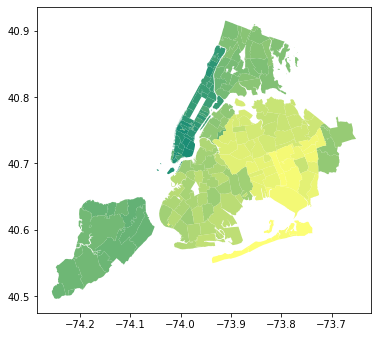

In [13]:
# plotting the pincode area map 


fig, ax = plt.subplots(figsize=(6,6), edgecolor='white',linewidth=3)
pincodes.plot(ax=ax,  alpha = 0.9, cmap='summer')
# pincodes.to_csv('./data/pincodes.csv')

# Spatial join 

Next step, we will perform a spatial join first on `geo_df` the taxi-geo dataset to that of the `pincodes` geodataframe and map out the location of `pickup points` and `dropoff points` separately - based on the zipcodes and the boro-codes information.


## Spatial join - Pickup coordinates

In [14]:
joined_p = gpd.sjoin(geo_df_p, pincodes, how='left', op='within')

print(joined_p.head())

   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  speed_kmph_m  day_name  hour  

In this view note that there are some NaN values. Most likely they correspond 
to the 'points' that lie outside of the polygon geometries. 

Lets verify this and separate the dataset into 2 sets

1. Rows that fall **'within'** the boundaries. 
2. Rows that all **'outside'** the boundaries.


In [15]:
#only for jfk airport

joined_p_jfk = joined_p.query('zcta == "11430"')
joined_p_jfk.to_csv('./data/joined_p_jfk.csv')


In [16]:
# picking the not null or `inliers` for further analysis

print(joined_p[joined_p.zcta.notnull()].shape)
joined_innyc_p = joined_p[joined_p.zcta.notnull()]

# picking the null dataset or `outliers `for further analysis.

print(joined_p[joined_p.zcta.isnull()].shape)
joined_outnyc_p = joined_p[joined_p.zcta.isnull()]


(1018105, 28)
(15555, 28)


In [17]:
#saving the dataframe for further analysis later

joined_innyc_p.to_csv('./data/joined_innyc_p.csv')
joined_outnyc_p.to_csv('./data/joined_outnyc_p.csv')

**Approx ~ 15,555 pickup observations** fall outside of the NYC borough boundary region.


## Spatial join - Dropoff coordinates

In [18]:
joined_d = gpd.sjoin(geo_df_d, pincodes, how='left', op='within')
print(joined_d.head())
print()

   Unnamed: 0         id  vendor_id      pickup_datetime     dropoff_datetime  \
0           0  id2966204          1  2016-05-01 10:37:00  2016-05-01 10:41:00   
1           1  id3871388          1  2016-06-13 09:46:00  2016-06-13 09:47:00   
2           2  id2922653          1  2016-05-02 11:27:00  2016-05-02 11:36:00   
3           3  id3882784          1  2016-03-21 08:11:00  2016-03-21 08:14:00   
4           4  id3958254          2  2016-04-19 13:59:00  2016-04-19 14:01:00   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.939331        40.805038         -73.939262   
1                1        -73.945457        40.751652         -73.945389   
2                1        -74.017143        40.704968         -74.017075   
3                1        -73.902061        40.763943         -73.902123   
4                1        -73.936905        40.764591         -73.936821   

   dropoff_latitude  ...  speed_kmph_m  day_name  hour  

In [19]:
# picking the not null or `inliers` for further analysis

print(joined_d[joined_d.zcta.notnull()].shape)
joined_innyc_d = joined_d[joined_d.zcta.notnull()]

# picking the null dataset or `outliers `for further analysis.

print(joined_d[joined_d.zcta.isnull()].shape)
joined_outnyc_d = joined_d[joined_d.zcta.isnull()]


(1016976, 28)
(16684, 28)


**Approx ~ 16,684 drop off observations** fall outside of the NYC borough boundary region.

In this view note that there are some NaN values. Most likely they correspond 
to the 'points' that lie outside of the polygon geometries. 

Lets verify this and separate the dataset into 2 sets

1. Rows that fall **'within'** the boundaries. 
2. Rows that all **'outside'** the boundaries.


In [20]:
#only for jfk airport

joined_d_jfk = joined_d.query('zcta == "11430"')
joined_d_jfk.to_csv('./data/joined_d_jfk.csv')
joined_d_jfk.sample(3)

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,speed_kmph_m,day_name,hour,price,month_name,day,geometry,index_right,zcta,bcode
1032750,1032750,id3946186,1,2016-02-22 05:18:00,2016-02-22 05:48:00,1,-73.946503,40.838058,-73.784592,40.643330,...,62.349623,Monday,5,150.120399,February,22,POINT (-73.78459 40.64333),202.0,11430,36081
1031386,1031386,id0974890,1,2016-03-05 15:06:00,2016-03-05 16:06:00,1,-73.964912,40.791832,-73.776382,40.645309,...,32.000384,Saturday,15,155.724039,March,5,POINT (-73.77638 40.64531),202.0,11430,36081
1013495,1013495,id2744836,2,2016-06-03 22:26:00,2016-06-03 23:13:00,1,-74.005753,40.706951,-73.790047,40.643299,...,39.881226,Friday,22,153.612512,June,3,POINT (-73.79005 40.64330),202.0,11430,36081


In [21]:
#saving the dataframe for further analysis later

joined_innyc_d.to_csv('./data/joined_innyc_d.csv')
joined_outnyc_d.to_csv('./data/joined_outnyc_d.csv')

## Geographical Mapping - Pickup Coordinates

### Q1. Which neighborhoods/zip codes tends to experience a relatively higher density of pick-ups? 

### Q3. Which neighborhoods/zip codes tends to have the highest duration-to-distance ratios, based on pick-up?

In [22]:
# Setting the index of pincodes to `zcta` 
# Grouping the data by zipcode and rounding up the count/value of pickup's/dur_to_dist helps us answer teh above q's

pincodes.set_index('zcta',inplace=True)

In [23]:
#creating new featurse to capture the 1. count of pickups for each zipcode location. 
# 2. dur_to_dist in seconds for each zipcode location

pincodes['zcta_count_p'] = joined_p['zcta'].value_counts()
pincodes['dur_to_dist_median_p'] = joined_p.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').round(2)


In [24]:
print(pincodes.shape)
print(pincodes.head())
print(pincodes.info())

(214, 4)
       bcode                                           geometry  zcta_count_p  \
zcta                                                                            
10001  36061  POLYGON ((-74.00368 40.74835, -74.00653 40.749...       51719.0   
10002  36061  POLYGON ((-73.99695 40.71207, -73.99712 40.712...       19332.0   
10003  36061  POLYGON ((-73.99206 40.72564, -73.99179 40.726...       54031.0   
10007  36061  POLYGON ((-74.01046 40.71153, -74.01015 40.712...        8150.0   
10009  36061  POLYGON ((-73.97521 40.71924, -73.97512 40.719...       19677.0   

       dur_to_dist_median_p  
zcta                         
10001                247.88  
10002                210.63  
10003                241.62  
10007                210.82  
10009                225.76  
<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 214 entries, 10001 to 11697
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----

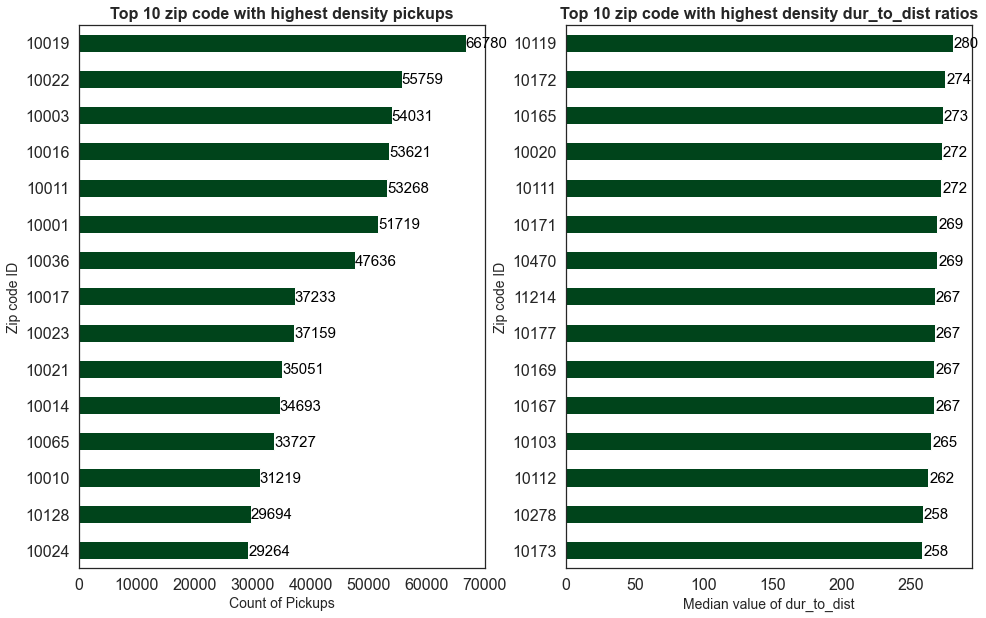

In [25]:
from matplotlib import style
#styles
sns.set_theme(style="white")

## plotting in subplots. 

fig = plt.figure(figsize=(16,10))

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

# mapping top 10 zipcodes that have highest pickup numbers


t15_p = joined_p['zcta'].value_counts().sort_values(ascending=False).head(15)
t15_p.plot.barh(ax=ax1, fontsize=16,cmap='Greens_r')
# t15_p.apply(lambda y: ax.annotate(text=y.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

ax1.set_xlabel('Count of Pickups', fontsize=14)
ax1.set_ylabel('Zip code ID', fontsize=14,)
ax1.set_title('Top 10 zip code with highest density pickups', fontsize=16, weight='bold') 
ax1.invert_yaxis()


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax1.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax1.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')
    


# mapping top 10 zipcodes that have highest dur_to_dist ratios


t15_dd_p = joined_p.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').sort_values(ascending=False).head(15).round(2)
t15_dd_p.plot.barh(ax=ax2, fontsize=16, cmap='Greens_r')
ax2.set_xlabel('Median value of dur_to_dist', fontsize=14)
ax2.set_ylabel('Zip code ID', fontsize=14,)
ax2.set_title('Top 10 zip code with highest density dur_to_dist ratios', fontsize=16, weight='bold')
ax2.invert_yaxis()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax2.patches:
    totals.append(i.get_width())

# # set individual bar labels using above list
# total = sum(totals)

# set individual bar labels using above list
for i in ax2.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax2.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')



<AxesSubplot:>

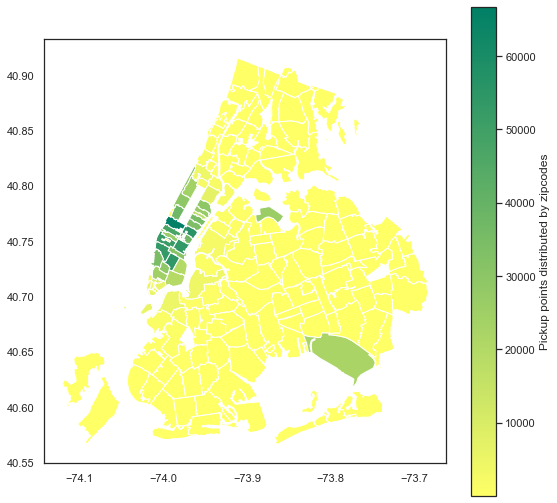

In [26]:
# fig, ax = plt.subplots(1, 1)


fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

pincodes.plot(column='zcta_count_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Pickup points distributed by zipcodes"})

<AxesSubplot:>

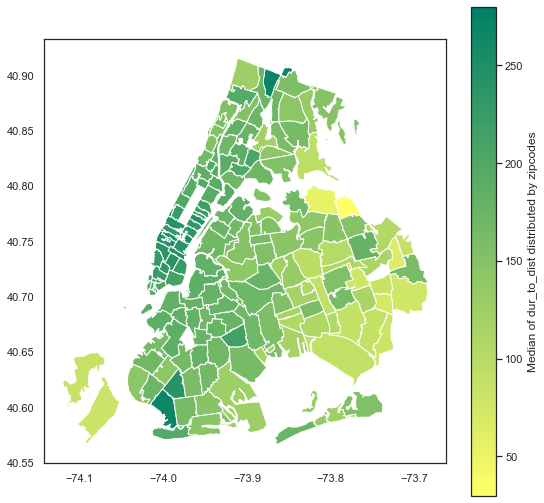

In [27]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

#label each zipcode with dur_to_dist_p
# pincodes.apply(lambda x: ax.annotate(text=x.dur_to_dist_median_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)



pincodes.plot(column='dur_to_dist_median_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Median of dur_to_dist distributed by zipcodes"})

## Sampling only the JFK airport pickups @ JFK with dropoffs clusters

In [28]:
geometry_d_jfk = [Point(xy) for xy in zip(joined_p_jfk['dropoff_longitude'], joined_p_jfk['dropoff_latitude'])]

In [29]:
crs ='epsg:4326'
geo_df_p_jfk = gpd.GeoDataFrame(joined_p_jfk, crs = crs, geometry = geometry_d_jfk)

In [30]:

geo_df_p_jfk.drop('index_right', inplace=True, axis=1)
geo_df_p_jfk.drop('zcta', inplace=True, axis=1)
geo_df_p_jfk.drop('bcode', inplace=True, axis=1)
geo_df_p_jfk.info(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 22226 entries, 22 to 1033651
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          22226 non-null  int64   
 1   id                  22226 non-null  object  
 2   vendor_id           22226 non-null  int64   
 3   pickup_datetime     22226 non-null  object  
 4   dropoff_datetime    22226 non-null  object  
 5   passenger_count     22226 non-null  int64   
 6   pickup_longitude    22226 non-null  float64 
 7   pickup_latitude     22226 non-null  float64 
 8   dropoff_longitude   22226 non-null  float64 
 9   dropoff_latitude    22226 non-null  float64 
 10  store_and_fwd_flag  22226 non-null  bool    
 11  duration            22226 non-null  int64   
 12  distance            22226 non-null  float64 
 13  manhattan_dist      22226 non-null  float64 
 14  duration_hours      22226 non-null  float64 
 15  duration_min        22226

In [68]:
geo_df_p_jfk_clusters = gpd.sjoin(geo_df_p_jfk, pincodes, how='left', op='within')

print(geo_df_p_jfk_clusters.sample(3))

geo_df_p_jfk_clusters.to_csv('./data/geo_df_p_jfk_clusters.csv')

         Unnamed: 0         id  vendor_id      pickup_datetime  \
1005493     1005493  id1330735          2  2016-01-20 21:12:00   
1000904     1000904  id3693882          2  2016-01-21 21:13:00   
998927       998927  id0459708          1  2016-01-11 00:31:00   

            dropoff_datetime  passenger_count  pickup_longitude  \
1005493  2016-01-20 21:37:00                1        -73.789963   
1000904  2016-01-21 21:39:00                2        -73.776749   
998927   2016-01-11 00:53:00                1        -73.776787   

         pickup_latitude  dropoff_longitude  dropoff_latitude  ...  \
1005493        40.643814         -73.964874         40.576054  ...   
1000904        40.645168         -73.864014         40.762112  ...   
998927         40.645264         -73.940369         40.680374  ...   

         index_right  bcode  zcta_count_p  dur_to_dist_median_p  \
1005493        11235  36047          17.0                145.30   
1000904        11369  36081         252.0          

## Mapping dropoffs from JFK to the geographic map

In [32]:
#creating new featurse to capture the 1. count of pickups for each zipcode location. 
# 2. dur_to_dist in seconds for each zipcode location

pincodes['zcta_count_p_jfk'] = geo_df_p_jfk_clusters['index_right'].value_counts()
pincodes['avg_hour_p_jfk'] = geo_df_p_jfk_clusters['hour'].agg('mean').round(2)

# pincodes['dur_to_dist_median_p_jfk'] = geo_df_p_jfk_clusters.groupby('index_right')['dur_to_dist_m_spkm'].agg('median').round(2)

In [33]:
pincodes.head()


,bcode,geometry,zcta_count_p,dur_to_dist_median_p,zcta_count_p_jfk,avg_hour_p_jfk
zcta,,,,,,
10001,36061,"POLYGON ((-74.00368 40.74835, -74.00653 40.749...",51719.0,247.88,665.0,14.45
10002,36061,"POLYGON ((-73.99695 40.71207, -73.99712 40.712...",19332.0,210.63,293.0,14.45
10003,36061,"POLYGON ((-73.99206 40.72564, -73.99179 40.726...",54031.0,241.62,520.0,14.45
10007,36061,"POLYGON ((-74.01046 40.71153, -74.01015 40.712...",8150.0,210.82,107.0,14.45
10009,36061,"POLYGON ((-73.97521 40.71924, -73.97512 40.719...",19677.0,225.76,271.0,14.45


<AxesSubplot:>

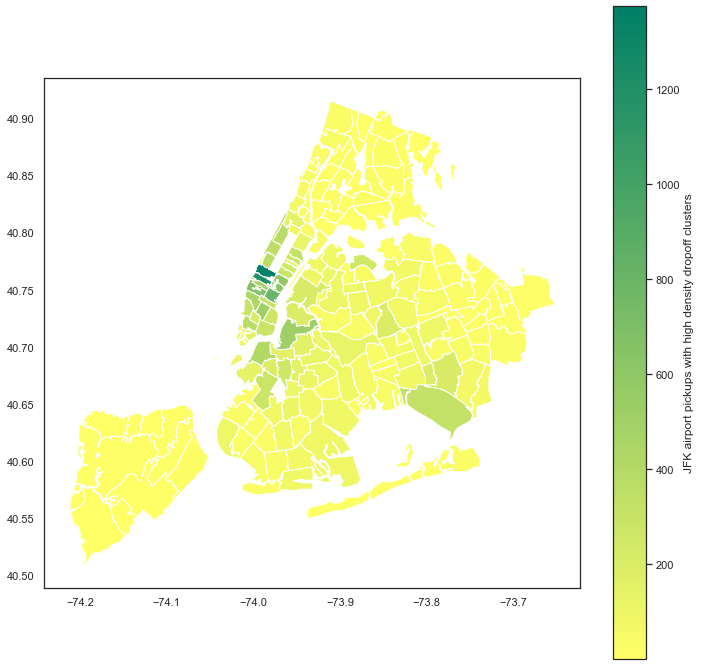

In [63]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(12,12), edgecolor='white',linewidth=4)

#label each zipcode with dur_to_dist_p
# pincodes.apply(lambda x: ax.annotate(text=x.zcta_count_p_jfk[:15], xy=x.geometry.centroid.coords[0], ha='center'),axis=1)



pincodes.plot(column='zcta_count_p_jfk', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "JFK airport pickups with high density dropoff clusters"})




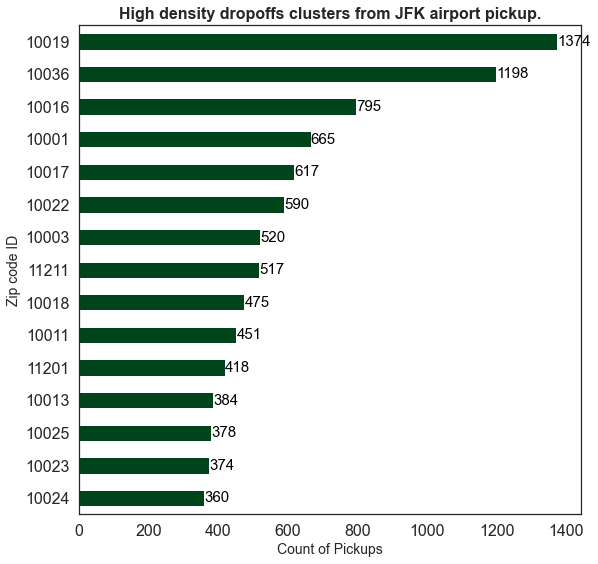

In [35]:
## plotting in subplots. 


fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

# mapping top 10 zipcodes that have highest pickup numbers

t15_p_jfk = geo_df_p_jfk_clusters['index_right'].value_counts().sort_values(ascending=False).head(15)
t15_p_jfk.plot.barh(ax=ax, fontsize=16,cmap='Greens_r')
# t15_p.apply(lambda y: ax.annotate(text=y.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

ax.set_xlabel('Count of Pickups', fontsize=14)
ax.set_ylabel('Zip code ID', fontsize=14,)
ax.set_title('High density dropoffs clusters from JFK airport pickup.', fontsize=16, weight='bold') 
ax.invert_yaxis()


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')
    


### Mapping Manhattan borough - Pickup

In [36]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_p',ascending=False)
pincodes_manhattan.head(12)


,bcode,geometry,zcta_count_p,dur_to_dist_median_p,zcta_count_p_jfk,avg_hour_p_jfk
zcta,,,,,,
10019,36061,"POLYGON ((-73.99270 40.76343, -73.99336 40.763...",66780.0,240.53,1374.0,14.45
10022,36061,"POLYGON ((-73.96934 40.76355, -73.96773 40.762...",55759.0,236.06,590.0,14.45
10003,36061,"POLYGON ((-73.99206 40.72564, -73.99179 40.726...",54031.0,241.62,520.0,14.45
10016,36061,"POLYGON ((-73.98362 40.74972, -73.98317 40.750...",53621.0,239.05,795.0,14.45
10011,36061,"POLYGON ((-74.00368 40.74835, -74.00351 40.748...",53268.0,237.16,451.0,14.45
10001,36061,"POLYGON ((-74.00368 40.74835, -74.00653 40.749...",51719.0,247.88,665.0,14.45
10036,36061,"POLYGON ((-73.99819 40.76492, -73.99774 40.765...",47636.0,230.26,1198.0,14.45
10017,36061,"POLYGON ((-73.96856 40.74743, -73.96878 40.747...",37233.0,249.51,617.0,14.45
10023,36061,"POLYGON ((-73.98011 40.77053, -73.98056 40.769...",37159.0,226.05,374.0,14.45


<AxesSubplot:>

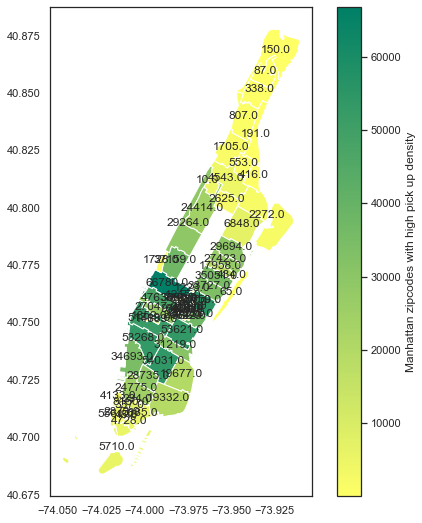

In [37]:

fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=2)

#label each zipcode with pickup count
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='zcta_count_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Manhattan zipcodes with high pick up density", })



### Mapping dur_to_dist - Pickup


<AxesSubplot:>

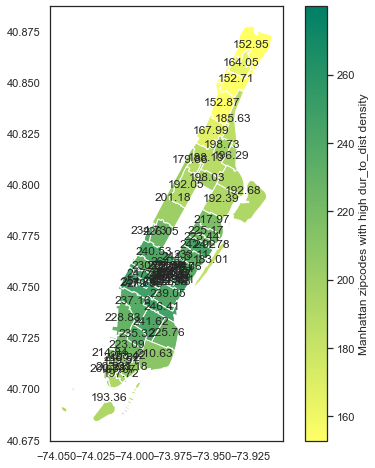

In [38]:
fig, ax = plt.subplots(figsize=(8,8), edgecolor='white',linewidth=4)


#label each zipcode with pickup count
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.dur_to_dist_median_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='dur_to_dist_median_p', 
            ax=ax,
            cmap = 'summer_r',  
            legend=True, 
            legend_kwds={'label': "Manhattan zipcodes with high dur_to_dist density"})#'orientation':'horizontal'


## Geographical Mapping - Dropoff Coordinates

### Q2. Which neighborhoods/zip codes tends to experience a relatively higher density of drop-offs?

### Q4. Which neighborhoods/zip codes tends to have the highest duration-to-distance ratios, based on drop-off?

In [39]:
pincodes['zcta_count_d'] = joined_d['zcta'].value_counts()
pincodes['dur_to_dist_median_d'] = joined_d.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').round(2)

In [40]:
print(pincodes.shape)
print(pincodes.head())
print(pincodes.info())

(214, 8)
       bcode                                           geometry  zcta_count_p  \
zcta                                                                            
10001  36061  POLYGON ((-74.00368 40.74835, -74.00653 40.749...       51719.0   
10002  36061  POLYGON ((-73.99695 40.71207, -73.99712 40.712...       19332.0   
10003  36061  POLYGON ((-73.99206 40.72564, -73.99179 40.726...       54031.0   
10007  36061  POLYGON ((-74.01046 40.71153, -74.01015 40.712...        8150.0   
10009  36061  POLYGON ((-73.97521 40.71924, -73.97512 40.719...       19677.0   

       dur_to_dist_median_p  zcta_count_p_jfk  avg_hour_p_jfk  zcta_count_d  \
zcta                                                                          
10001                247.88             665.0           14.45       51840.0   
10002                210.63             293.0           14.45       17823.0   
10003                241.62             520.0           14.45       44584.0   
10007                210.82 

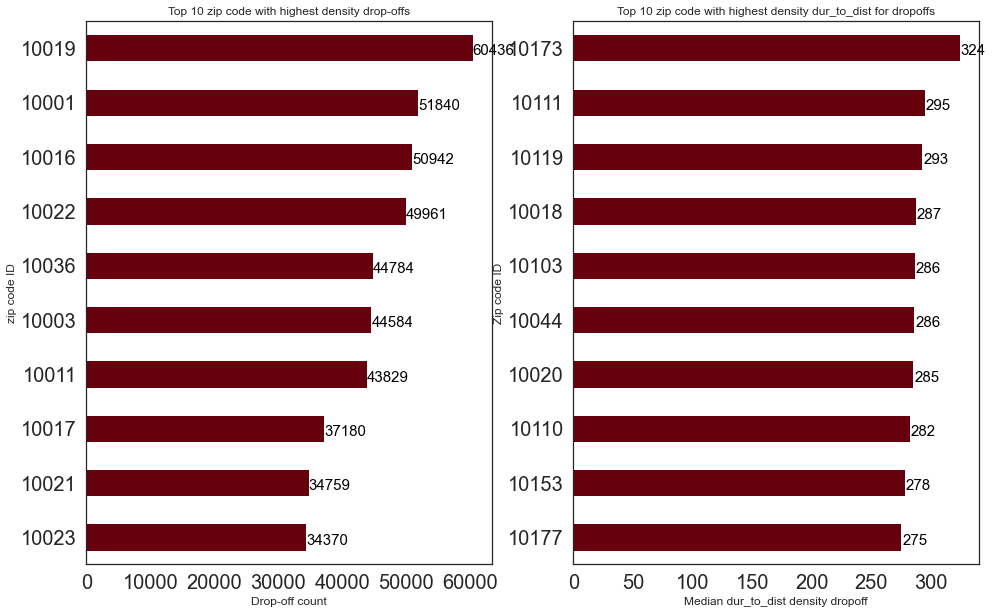

In [41]:
## plotting in subplots. 

fig = plt.figure(figsize=(16,10))

ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

# mapping top 10 zipcodes that have highest density drop-offs


joined_d['zcta'].value_counts().sort_values(ascending=False).head(10).plot.barh(ax=ax1, fontsize=20, cmap='Reds_r')
ax1.set_xlabel('Drop-off count')
ax1.set_ylabel('zip code ID')
ax1.set_title('Top 10 zip code with highest density drop-offs')
ax1.invert_yaxis()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax1.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax1.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax1.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')
    

# mapping top 10 zipcodes that have highest density drop-offs

joined_d.groupby('zcta')['dur_to_dist_m_spkm'].agg('median').sort_values(ascending=False).head(10).plot.barh(ax=ax2, fontsize=20, cmap='Reds_r')
ax2.set_xlabel('Median dur_to_dist density dropoff')
ax2.set_ylabel('Zip code ID')
ax2.set_title('Top 10 zip code with highest density dur_to_dist for dropoffs')
# invert for largest on top 
ax2.invert_yaxis()

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax2.patches:
    totals.append(i.get_width())

# # set individual bar labels using above list
# total = sum(totals)

# set individual bar labels using above list
for i in ax2.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax2.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')



<AxesSubplot:>

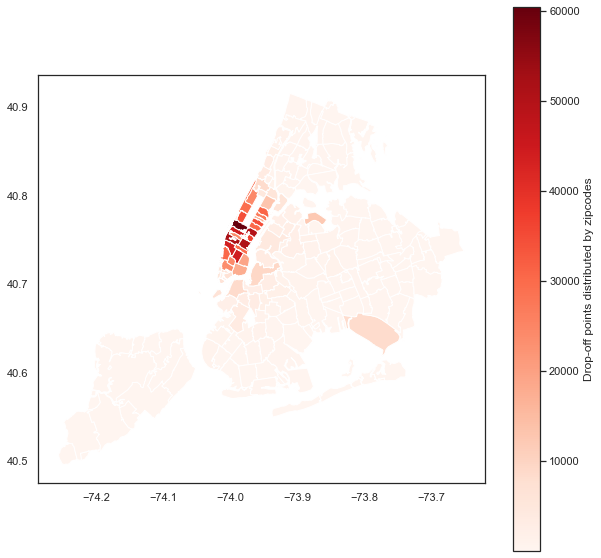

In [42]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(10,10), edgecolor='white',linewidth=4)
pincodes.plot(column='zcta_count_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Drop-off points distributed by zipcodes"})

### Mapping dur_to_dist - Dropoff


<AxesSubplot:>

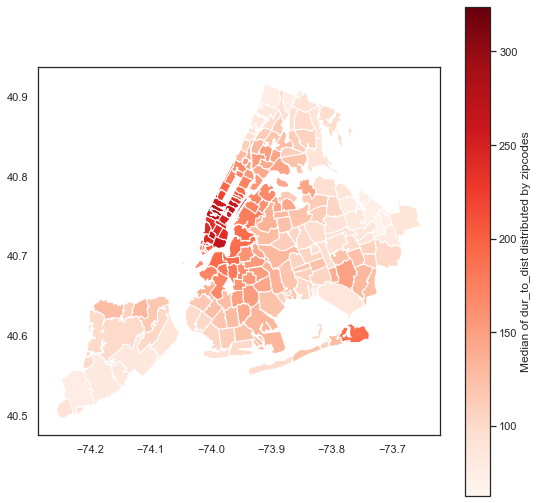

In [43]:

fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=2)

#label each zipcode with dur_to_dist_p
# pincodes.apply(lambda x: ax.annotate(text=x.dur_to_dist_mean_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


pincodes.plot(column='dur_to_dist_median_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Median of dur_to_dist distributed by zipcodes"})

In [44]:
pincodes.to_csv('./data/pincodes_choro.csv')

## Sampling only the JFK airport dropoffs @ JFK with pickup clusters

In [45]:
geometry_p_jfk = [Point(xy) for xy in zip(joined_d_jfk['pickup_longitude'], joined_d_jfk['pickup_latitude'])]

In [46]:
crs ='epsg:4326'
geo_df_d_jfk = gpd.GeoDataFrame(joined_d_jfk, crs = crs, geometry = geometry_p_jfk)

In [47]:

geo_df_d_jfk.drop('index_right', inplace=True, axis=1)
geo_df_d_jfk.drop('zcta', inplace=True, axis=1)
geo_df_d_jfk.drop('bcode', inplace=True, axis=1)
geo_df_d_jfk.info(3)

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 8397 entries, 22 to 1033373
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Unnamed: 0          8397 non-null   int64   
 1   id                  8397 non-null   object  
 2   vendor_id           8397 non-null   int64   
 3   pickup_datetime     8397 non-null   object  
 4   dropoff_datetime    8397 non-null   object  
 5   passenger_count     8397 non-null   int64   
 6   pickup_longitude    8397 non-null   float64 
 7   pickup_latitude     8397 non-null   float64 
 8   dropoff_longitude   8397 non-null   float64 
 9   dropoff_latitude    8397 non-null   float64 
 10  store_and_fwd_flag  8397 non-null   bool    
 11  duration            8397 non-null   int64   
 12  distance            8397 non-null   float64 
 13  manhattan_dist      8397 non-null   float64 
 14  duration_hours      8397 non-null   float64 
 15  duration_min        8397 n

In [48]:
geo_df_d_jfk.sample(3)

,Unnamed: 0,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,...,duration_min,dur_to_dist_m_hpkm,dur_to_dist_m_spkm,speed_kmph_m,day_name,hour,price,month_name,day,geometry
1022607,1022607,id3483186,2,2016-02-02 05:42:00,2016-02-02 06:10:00,1,-73.956589,40.775436,-73.780174,40.645840,...,28.433333,0.016151,58.142232,61.917127,Tuesday,5,144.093008,February,2,POINT (-73.95659 40.77544)
1020122,1020122,id0327521,2,2016-06-26 15:45:00,2016-06-26 16:43:00,1,-74.004982,40.729923,-73.790733,40.644287,...,58.233333,0.030166,108.596296,33.150302,Sunday,15,157.815053,June,26,POINT (-74.00498 40.72992)
1009812,1009812,id1226201,1,2016-02-04 06:03:00,2016-02-04 06:31:00,1,-73.985222,40.722851,-73.793564,40.644646,...,28.366667,0.016382,58.973428,61.044441,Thursday,6,141.760840,February,4,POINT (-73.98522 40.72285)


In [67]:
geo_df_d_jfk_clusters = gpd.sjoin(geo_df_d_jfk, pincodes, how='left', op='within')

print(geo_df_d_jfk_clusters.sample(3))

geo_df_d_jfk_clusters.to_csv('./data/geo_df_d_jfk_clusters.csv')

         Unnamed: 0         id  vendor_id      pickup_datetime  \
1014564     1014564  id3339410          2  2016-01-14 12:06:00   
1017878     1017878  id3072930          2  2016-04-14 04:43:00   
1015970     1015970  id0158620          1  2016-03-22 06:17:00   

            dropoff_datetime  passenger_count  pickup_longitude  \
1014564  2016-01-14 12:30:00                1        -73.950409   
1017878  2016-04-14 05:09:00                2        -73.986549   
1015970  2016-03-22 06:49:00                1        -73.975410   

         pickup_latitude  dropoff_longitude  dropoff_latitude  ...  \
1014564        40.775463         -73.785904         40.649441  ...   
1017878        40.750385         -73.790108         40.646847  ...   
1015970        40.752125         -73.789299         40.641823  ...   

         index_right  bcode  zcta_count_p  dur_to_dist_median_p  \
1014564        10028  36061       27423.0                225.17   
1017878        10018  36061       27047.0          

## Mapping pickups to JFK to the geographic map

In [50]:
#creating new featurse to capture the 1. count of pickups for each zipcode location. 
# 2. dur_to_dist in seconds for each zipcode location

pincodes['zcta_count_d_jfk'] = geo_df_d_jfk_clusters['index_right'].value_counts()
pincodes['avg_hour_d_jfk'] = geo_df_d_jfk_clusters['hour'].agg('mean').round(2)

# pincodes['dur_to_dist_median_p_jfk'] = geo_df_p_jfk_clusters.groupby('index_right')['dur_to_dist_m_spkm'].agg('median').round(2)

<AxesSubplot:>

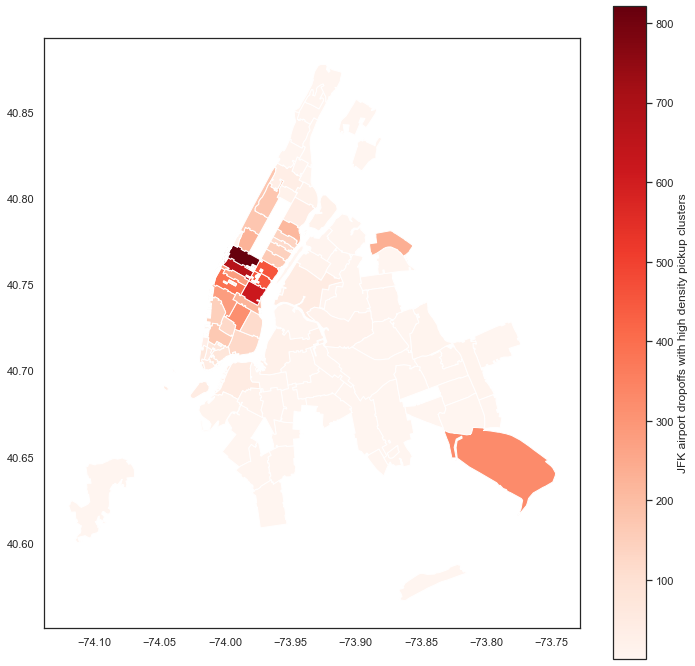

In [65]:
# fig, ax = plt.subplots(1, 1)

fig, ax = plt.subplots(figsize=(12,12), edgecolor='white',linewidth=4)

#label each zipcode with dur_to_dist_p
# pincodes.apply(lambda x: ax.annotate(text=x.dur_to_dist_median_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)


pincodes.plot(column='zcta_count_d_jfk', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "JFK airport dropoffs with high density pickup clusters"})



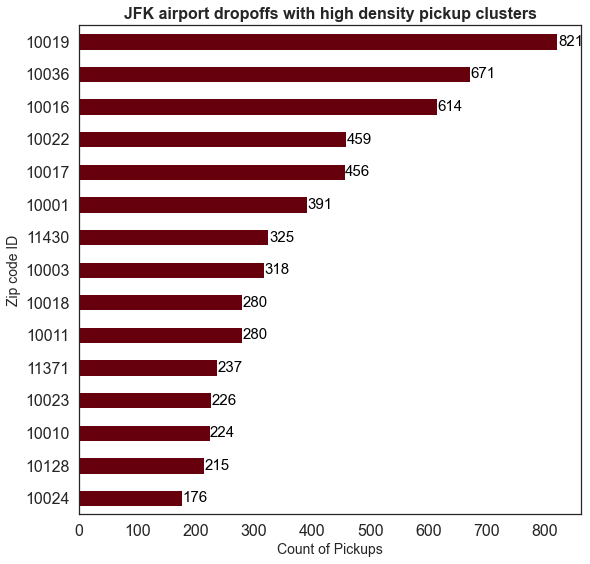

In [66]:
## plotting in subplots. 


fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

# mapping top 10 zipcodes that have highest pickup numbers

t15_d_jfk = geo_df_d_jfk_clusters['index_right'].value_counts().sort_values(ascending=False).head(15)
t15_d_jfk.plot.barh(ax=ax, fontsize=16,cmap='Reds_r')
# t15_p.apply(lambda y: ax.annotate(text=y.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

ax.set_xlabel('Count of Pickups', fontsize=14)
ax.set_ylabel('Zip code ID', fontsize=14,)
ax.set_title('JFK airport dropoffs with high density pickup clusters', fontsize=16, weight='bold') 
ax.invert_yaxis()


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')
    


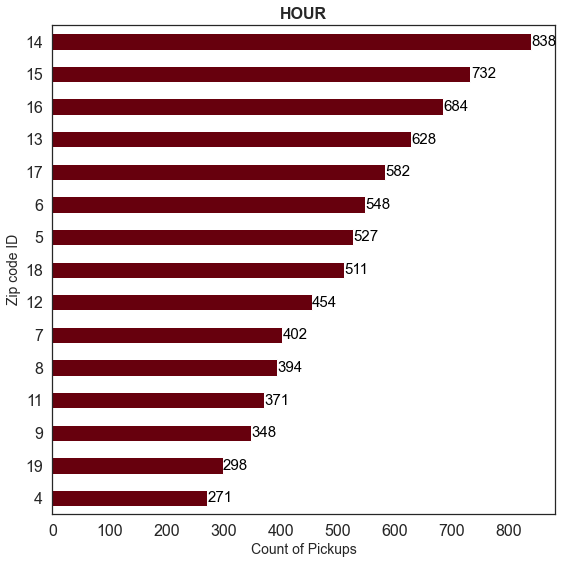

In [73]:
## plotting in subplots. 


fig, ax = plt.subplots(figsize=(9,9), edgecolor='white',linewidth=4)

# mapping top 10 zipcodes that have highest pickup numbers

t15_d_jfk_hour = geo_df_d_jfk_clusters['hour'].value_counts().head(15)
t15_d_jfk_hour.plot.barh(ax=ax, fontsize=16,cmap='Reds_r')
# t15_p.apply(lambda y: ax.annotate(text=y.zcta_count_p, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

ax.set_xlabel('Count of Pickups', fontsize=14)
ax.set_ylabel('Zip code ID', fontsize=14,)
ax.set_title('HOUR', fontsize=16, weight='bold') 
ax.invert_yaxis()


# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar labels using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+0.9, i.get_y()+.38, str(round(i.get_width())), fontsize=15, color='black')
    


### Mapping Manhattan borough - Dropoff

In [54]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_d',ascending=False).head(10)


<AxesSubplot:>

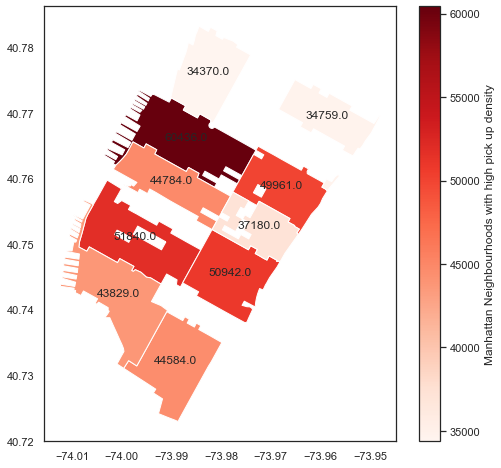

In [55]:

fig, ax = plt.subplots(figsize=(8,8), edgecolor='white',linewidth=2)

#label each zipcode
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.zcta_count_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='zcta_count_d', 
            ax=ax,
            cmap = 'Reds',  
            legend=True, 
            legend_kwds={'label': "Manhattan Neighbourhoods with high pick up density"})



In [56]:
# quering the dataset by limiting the output to 'Manhattan' alone with borough code = 36061.

pincodes_manhattan = pincodes.query('bcode == "36061"').sort_values(by='zcta_count_d',ascending=False).head(10)

<AxesSubplot:>

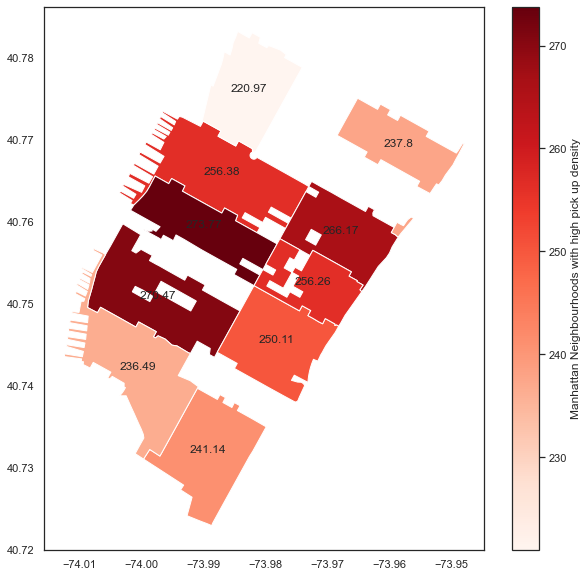

In [57]:
## plotting in subplots. 

fig,ax = plt.subplots(figsize=(10,10))


#label each zipcode
pincodes_manhattan.apply(lambda x: ax.annotate(text=x.dur_to_dist_median_d, xy=x.geometry.centroid.coords[0], ha='center'),axis=1)

pincodes_manhattan.plot(column='dur_to_dist_median_d', 
            ax=ax,
            cmap = 'Reds', 
            legend=True, 
            legend_kwds={'label': "Manhattan Neighbourhoods with high pick up density"})



Q5. For any of the neighborhoods identified, are there any potential areas within the neighborhood that are optimal for flying taxi pick-up / drop-off? What makes them suitable?

Answers provided in the presentation with the geographical maps from kepler GIS library.